**Name : Sayantani Saha , Suneha sen**

Roll no. : MDS202345, MDS202351

**METHODOLOGY :**  For the first data set which is a customer churn dataset, we build two classifiers Random Forest and AdaBoost and compare the models. An appropriate metric for this case would be the recall.

Before proceeding further , we perform the train-test split based on the outcome. This approach helps achieve realistic modelling since we use test data only during evluation and eclipse it from all the pre processing steps. Without it, there is a chance of information leakage from test data.

In [ ]:
!pip install matplotlib-venn

In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install memory_profiler

In [ ]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import statsmodels.api as sm

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as me
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

%load_ext memory_profiler
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

### Utility Functions

In [ ]:
def correlation_heatmap(df, numerical_columns):
    # Create a correlation heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
    plt.title('Correlation Heatmap')
    plt.show()

def summary_stat_columns(df):
    # Print summary statistics for numerical columns
    print("Summary statistics for numerical columns")
    print(df.describe())
    # Summary statistics for categorical columns
    print("\nSummary statistics for categorical columns")
    print(df.describe(include='object'))
    # Check for missing values
    print("\nMissing values")
    print(df.isnull().sum(), end='\n\n')

def get_numerical_and_categorical_columns(df):
    # Get numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    # Get categorical columns
    categorical_columns = df.columns.difference(numerical_columns).to_list()
    return numerical_columns, categorical_columns

def plot_distribution_numerical(df, numerical_columns):
    # Plot distribution of numerical columns
    # Determine the number of rows needed for the subplots
    n_rows = len(numerical_columns)
    fig, axs = plt.subplots(n_rows, 2, figsize=(10, 2*n_rows))
    if n_rows > 1:
        axs = axs.flatten()
    for i, col in enumerate(numerical_columns):
        # histogram
        sns.histplot(df[col], kde=True, ax=axs[i*2])
        axs[i*2].set_title(f'Distribution of {col}')
        # boxplot
        sns.boxplot(x=df[col], ax=axs[i*2+1])
        axs[i*2+1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

def plot_count_categorical(df, categorical_columns):
    # Countplot of categorical columns
    n_rows = int(np.ceil(len(categorical_columns) / 2))
    fig, axs = plt.subplots(n_rows, 2, figsize=(10, 3*n_rows))
    axs = axs.flatten()
    for i, col in enumerate(categorical_columns):
        # countplot
        sns.countplot(x=df[col], ax=axs[i])
        axs[i].set_title(f'Countplot of {col}')
    # Remove unused subplots
    if len(categorical_columns) % 2:
        fig.delaxes(axs[-1])
    plt.tight_layout()
    plt.show()

# Custom transformer for removing outliers from a specific column
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, threshold=3):
        self.column_name = column_name
        self.threshold = threshold
        self.outliers_removed = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mask = (X[self.column_name] - X[self.column_name].mean()).abs() <= (self.threshold * X[self.column_name].std())
        self.outliers_removed = len(X) - mask.sum()
        return X[mask]

# Get train test data along with preprocessing pipeline
def get_data(df, cols_to_remove, target, outlier_col=None, classification=True, process_target=False, preprocess=True):
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # print the shape of the training and test sets
    print('Shape of training set:', X_train.shape, y_train.shape)
    print('Shape of test set:', X_test.shape, y_test.shape)

    preprocessor = {}
    if preprocess:
        # Define the numerical and categorical columns
        numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_columns = X_train.columns.difference(numerical_columns).to_list()
        # Remove columns to be dropped
        for col in cols_to_remove:
            if col in numerical_columns:
                numerical_columns.remove(col)
            elif col in categorical_columns:
                categorical_columns.remove(col)
        print('numerical_columns in training data:', numerical_columns)
        print('categorical_columns in training data:', categorical_columns)
        # Preprocessing for numerical data
        if outlier_col is not None:
            steps = [
                ('outlier_remover', OutlierRemover(column_name=outlier_col, threshold=3)),
                ('scaler', StandardScaler())
            ]
        else:
            steps = [
                ('scaler', StandardScaler())
            ]
        numerical_transformer = Pipeline(steps=steps)

        # Preprocessing for categorical data
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        # Bundle preprocessing for numerical and categorical data
        preprocessor['covariate'] = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_columns),
                ('cat', categorical_transformer, categorical_columns)
            ])
        # Preprocessor for the target variable
        if classification:
            preprocessor['target'] = LabelEncoder()
        else:
            if process_target:
                preprocessor['target'] = StandardScaler()

    return X_train, X_test, y_train, y_test, preprocessor

# Execute preprocessing pipeline on data
def preprocess_data(X, y, preprocessor, train_data=True, classification=True):
    if train_data:
        # Preprocessing of training data, fit the preprocessor
        X = preprocessor['covariate'].fit_transform(X)
        if classification:
            y = preprocessor['target'].fit_transform(y)
        else:
            if 'target' in preprocessor.keys():
                y = preprocessor['target'].fit_transform(y.values.reshape(-1, 1))
    else:
        # Preprocessing of test data, only transform the data
        X = preprocessor['covariate'].transform(X)
        if classification:
            y = preprocessor['target'].transform(y)
        else:
            if 'target' in preprocessor.keys():
                y = preprocessor['target'].transform(y.values.reshape(-1, 1))

    return X, y, preprocessor

## Function to Plot Precision-Recall Curve
def plot_pr_curve(y_test, model_probs, name, ax):
    precision, recall, _ = me.precision_recall_curve(y_test, model_probs)

    ax.plot(recall, precision, marker='.', label=name)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title("PR Curve for {}".format(name))
    ax.legend()

    return ax
# Function to plot ROC Curve

def plot_roc_curve(y_test, model_probs,name, ax):
    fpr, tpr, _ = me.roc_curve(y_test, model_probs)

    ax.plot(fpr, tpr, marker='.', label=name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title("PR Curve for {}".format(name))
    ax.legend()

    return ax

# Function to Plot Confusion Matrix
def plot_conf_matrix(y_pred, y_test, ax, normalize="true"):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    cf_mat = me.confusion_matrix(y_test, y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_mat.flatten()]
    cf_mat = me.confusion_matrix(y_test, y_pred, normalize=normalize)
    group_percentages = ['{0:.2%}'.format(value) for value in cf_mat.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_mat, annot=labels, fmt='', cmap='RdPu', ax=ax)
    ax.set_title('Confusion Matrix [{} Normalized]'.format(normalize.capitalize()))
    ax.set_ylabel("True Class")
    ax.set_xlabel("Predicted Class")
    return ax

# Evaluation of Mode with Several Metrics
def result_disp(model, X_train, X_test, y_train, y_test, name):
    y_pred = model.predict(X_train)
    print('\nTraining Data Scores:')
    print('Precision: {:0.6f}'.format(me.precision_score(y_train, y_pred)))
    print('Recall: {:0.6f}'.format(me.recall_score(y_train, y_pred)))
    print('F-Score: {:0.6f}'.format(me.f1_score(y_train, y_pred)))
    print('Accuracy: {:0.6f}'.format(me.accuracy_score(y_train, y_pred)))

    y_pred = model.predict(X_test)
    print('\nTest Data Scores:')
    print('Precision: {:0.6f}'.format(me.precision_score(y_test, y_pred)))
    print('Recall: {:0.6f}'.format(me.recall_score(y_test, y_pred)))
    print('F-Score: {:0.6f}'.format(me.f1_score(y_test, y_pred)))
    print('Accuracy: {:0.6f}\n\n'.format(me.accuracy_score(y_test, y_pred)))

    # Calculate Posterior Probs
    yhat = model.predict_proba(X_test)
    model_probs = yhat[:, 1]

    # Figure Generation for Subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    # Calculate the Precision-Recall AUC
    precision, recall, _ = me.precision_recall_curve(y_test, model_probs)
    auc_score = me.auc(recall, precision)

    ax[0, 0] = plot_pr_curve(y_test, model_probs, name, ax[0, 0])
    ax[0, 0].axvline(x = me.recall_score(y_test,y_pred), linestyle='--', c='r')
    ax[0, 0].axhline(y = me.precision_score(y_test,y_pred), linestyle='--', c='r')
    ax[0, 0].set_title('PR AUC: {}'.format(np.round(auc_score,3)), fontsize=12)

    # Calculate the ROC Area Under Curve
    roc_auc = me.roc_auc_score(y_test, model_probs)

    ax[0, 1] = plot_roc_curve(y_test, model_probs, name, ax=ax[0, 1])
    ax[0, 1].set_title('ROC AUC {}'.format(np.round(roc_auc,3)),fontsize=12)

    # Plotting Confusion Matrix with Truth axis normalized.
    ax[1, 0] = plot_conf_matrix(y_pred, y_test, ax=ax[1, 0], normalize="true")

    # Plotting Confusion Matrix with Prediction axis normalized.
    ax[1, 1] = plot_conf_matrix(y_pred, y_test, ax=ax[1, 1], normalize="pred")

    fig.suptitle('Result for {} on Test Data'.format(name), fontsize=18)
    plt.show()

# Function to plot linear regression diagnostics
def lm_plot_diagnostics(model):
    residuals = model.resid
    fitted = model.fittedvalues
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # QQ plot
    sm.qqplot(residuals, line='s', ax=axs[0])
    axs[0].set_title('QQ Plot')

    # Residuals vs Fitted plot
    axs[1].scatter(fitted, residuals)
    axs[1].axhline(y=0, color='r', linestyle='--')
    axs[1].set_title('Residuals vs Fitted')
    axs[1].set_xlabel('Fitted values')
    axs[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

# Function to report the performance of regression model
def regression_report(model, X_train, y_train, X_test, y_test, preprocessor):
    # Predicting the training and testing set results
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_unnormalized = preprocessor['target'].inverse_transform(y_train.reshape(-1, 1))
    y_test_unnormalized = preprocessor['target'].inverse_transform(y_test.reshape(-1, 1))
    y_train_pred_unnormalized = preprocessor['target'].inverse_transform(y_train_pred.reshape(-1, 1))
    y_test_pred_unnormalized = preprocessor['target'].inverse_transform(y_test_pred.reshape(-1, 1))

    # Calculating MSE for training and testing sets
    mse_train = me.mean_squared_error(y_train, y_train_pred)
    mse_test = me.mean_squared_error(y_test, y_test_pred)
    mse_train_unnormalized = me.mean_squared_error(y_train_unnormalized, y_train_pred_unnormalized)
    mse_test_unnormalized = me.mean_squared_error(y_test_unnormalized, y_test_pred_unnormalized)

    # Calculating R^2 for training and testing sets
    r2_train = me.r2_score(y_train, y_train_pred)
    r2_test = me.r2_score(y_test, y_test_pred)
    r2_train_unnormalized = me.r2_score(y_train_unnormalized, y_train_pred_unnormalized)
    r2_test_unnormalized = me.r2_score(y_test_unnormalized, y_test_pred_unnormalized)

    # Printing the metrics
    print(f'Training MSE: {mse_train}')
    print(f'Test MSE: {mse_test}')
    print(f'Training R^2: {r2_train}')
    print(f'Test R^2: {r2_test}')
    print(f'Training MSE (Unnormalized): {mse_train_unnormalized}')
    print(f'Test MSE (Unnormalized): {mse_test_unnormalized}')
    print(f'Training R^2 (Unnormalized): {r2_train_unnormalized}')
    print(f'Test R^2 (Unnormalized): {r2_test_unnormalized}')

# Baseline Model for random guessing
class Baseline:
    def __init__(self, y_train):
        self.class_prob = np.array([1-y_train.mean(), y_train.mean()]).reshape(1, -1)

    def predict(self, data):
        return np.random.choice([0, 1], size=(data.shape[0],1), p = self.class_prob.ravel(), )

    def predict_proba(self, data):
        return np.repeat(self.class_prob, data.shape[0], axis=0)

# Defnine a simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return self.sigmoid(x)

# Function to train the neural network
def train_nn(ann, train_loader, epochs=100, lr=0.01):
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(ann.parameters(), lr=lr)

    # Train the neural network model
    epochs = 1000
    for epoch in range(epochs):
        ann.train()  # Set the model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = ann(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Hyperparameter Search
def bayes_opt_search(model, search_space, X_train, y_train, regression=False):
    # Initialize the stratified k-fold object
    cv = StratifiedKFold(n_splits=5)
    # Initialize the BayesSearchCV object
    if not regression:
        opt = BayesSearchCV(model, search_space, cv=cv, n_jobs=-1, n_iter=50, random_state=42, verbose=0)
    else:
        opt = BayesSearchCV(model, search_space, cv=5, n_jobs=-1, n_iter=50, random_state=42, verbose=0, scoring='neg_mean_squared_error')
    # Fit the BayesSearchCV object to the data
    opt.fit(X_train, y_train)
    # Print the best parameters
    print("Best Parameters: ", opt.best_params_)
    return opt

## Task 1: Customer Churn Prediction

**Data Description** : This dataset captures customer's interaction with an online retail store. We predict the customer's churn by analysing the columns such as age, gender, emailoptin in categorical attributes and number of purchases, years as customer etc as the numerical attributes.

### Exploratory Data-Analysis

In [ ]:
df = pd.read_csv('customer-churn-data.csv')
df.head()

,CustomerID,Age,Gender,AnnualIncome,TotalSpend,YearsAsCustomer,NumOfPurchases,AvgTransactionAmount,NumOfReturns,NumOfSupportQueries,SatisfactionScore,LastPurchaseDaysAgo,EmailOptIn,PromotionResponse,Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


In [ ]:
# Check summary statistics
summary_stat_columns(df)

Summary statistics for numerical columns
        CustomerID          Age  AnnualIncome  TotalSpend  YearsAsCustomer  \
count  1000.000000  1000.000000   1000.000000  1000.00000      1000.000000   
mean    500.500000    43.267000    111.962960  5080.79265         9.727000   
std     288.819436    15.242311     52.844111  2862.12335         5.536346   
min       1.000000    18.000000     20.010000   108.94000         1.000000   
25%     250.750000    30.000000     67.800000  2678.67500         5.000000   
50%     500.500000    43.000000    114.140000  4986.19500         9.000000   
75%     750.250000    56.000000    158.452500  7606.47000        14.000000   
max    1000.000000    69.000000    199.730000  9999.64000        19.000000   

       NumOfPurchases  AvgTransactionAmount  NumOfReturns  \
count     1000.000000           1000.000000   1000.000000   
mean        49.456000            266.876530      4.612000   
std         28.543595            145.873445      2.896869   
min         

In [ ]:
# Separating all the numerical columns and categorical columns
numerical_columns, categorical_columns = get_numerical_and_categorical_columns(df)

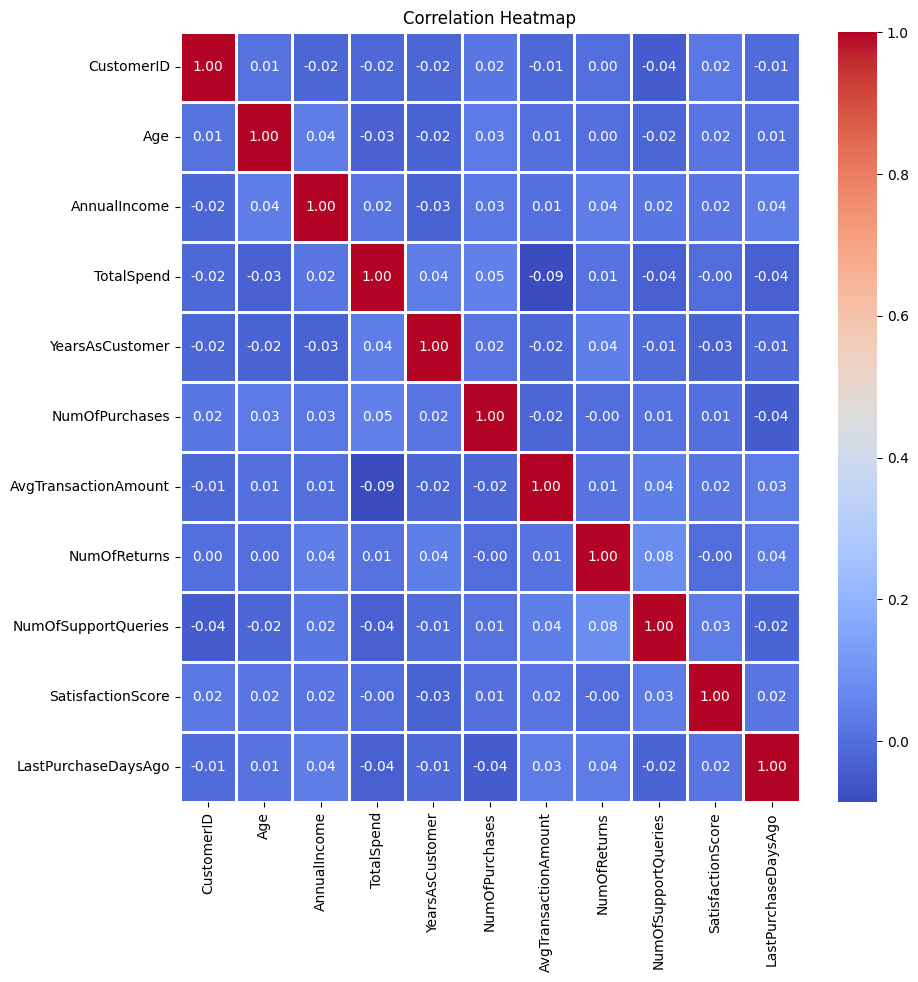

In [ ]:
# Correlation heatmap of numerical features
correlation_heatmap(df, numerical_columns)

There is no significant correlation between any of the numerical attributes. So we do not need to drop any attribute. We proceed further.

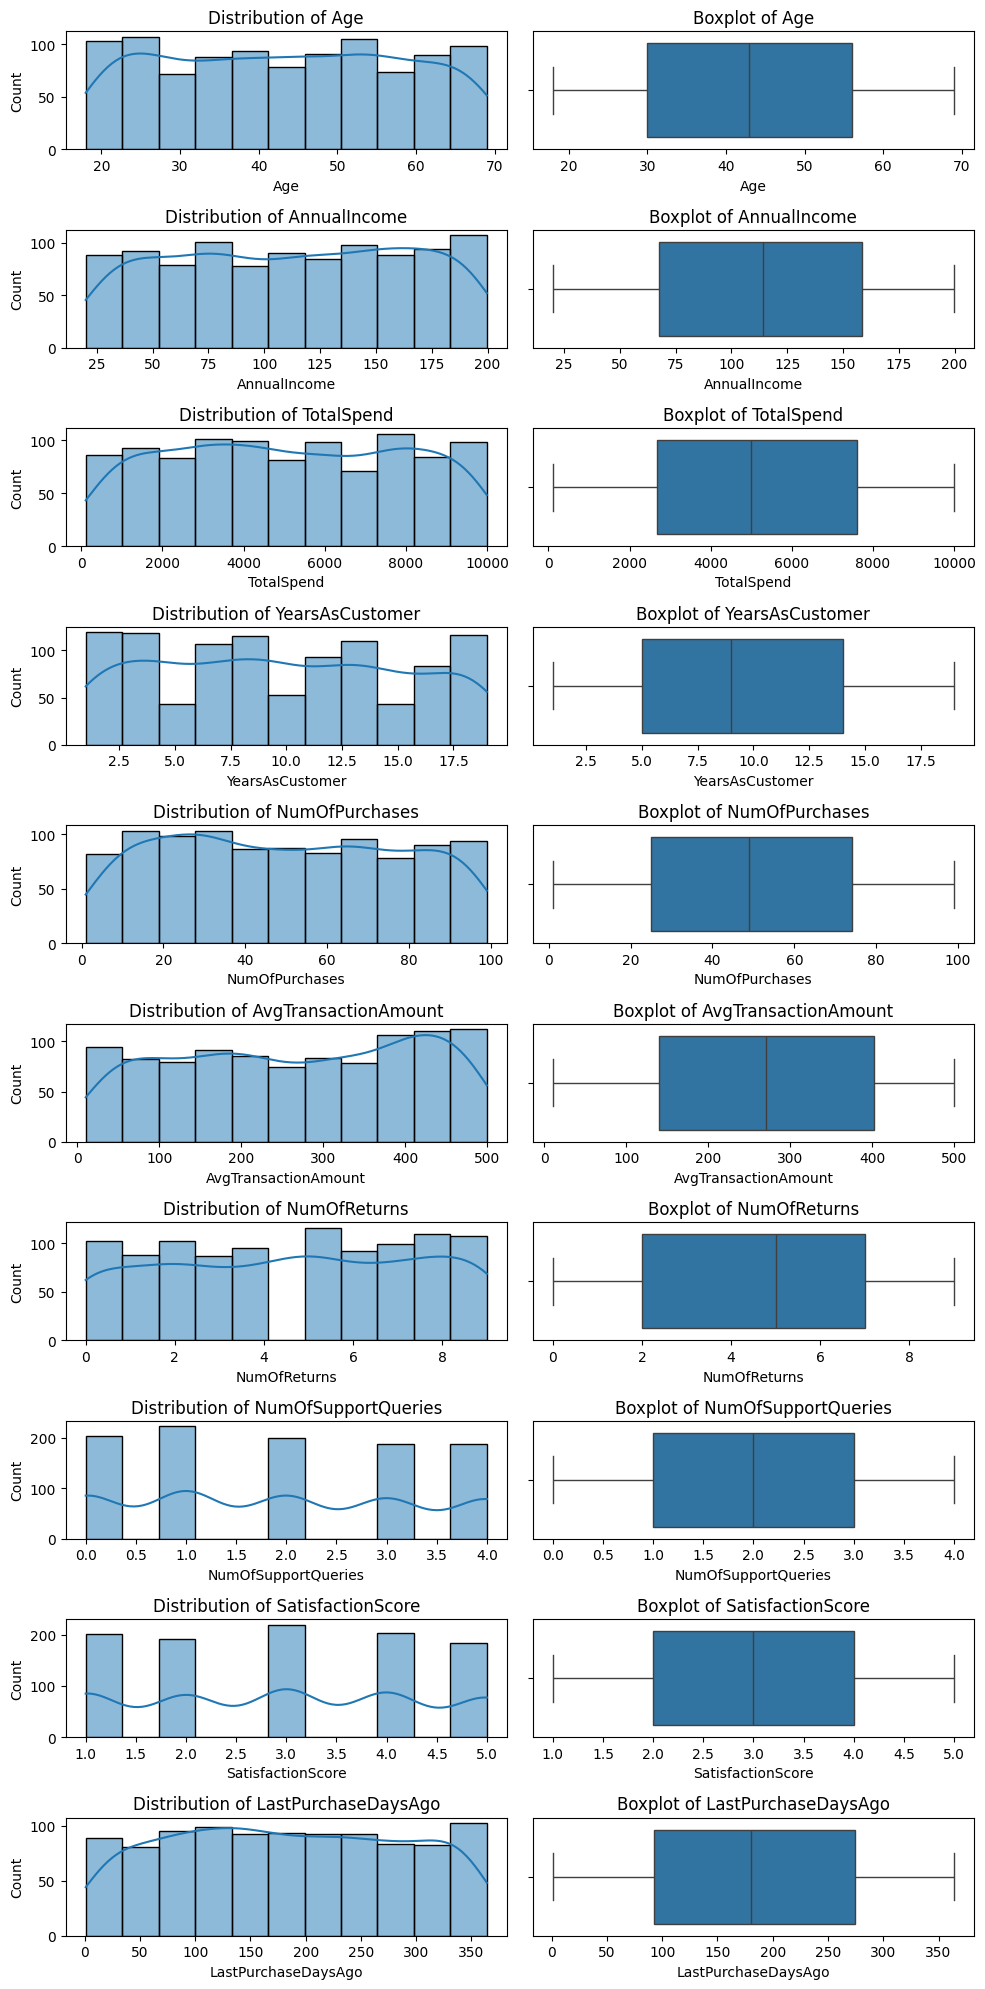

In [ ]:
# Remove 'CustomerID' from the list if it exists
if 'CustomerID' in numerical_columns:
    numerical_columns.remove('CustomerID')
plot_distribution_numerical(df, numerical_columns)

We check for the distribution of the individual numerical attributes. None of them is imbalanced.

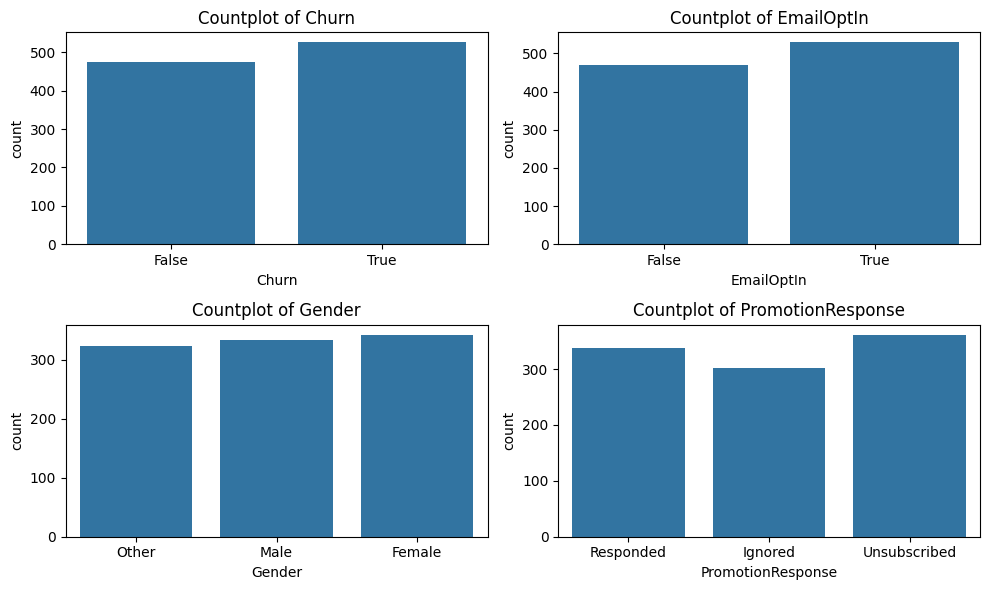

In [ ]:
plot_count_categorical(df, categorical_columns)

We check for the distribution of the individual categorical attributes. None of them is imbalanced.

### Data Pre-Processing

In [ ]:
# Get train test data along with preprocessing pipeline
X_train, X_test, y_train, y_test, preprocessor = get_data(df, ['CustomerID'], 'Churn') # Removing just the CustomerID column
X_train, y_train, preprocessor = preprocess_data(X_train, y_train, preprocessor, train_data=True)
X_test, y_test, preprocessor = preprocess_data(X_test, y_test, preprocessor, train_data=False)

# Sanity check (Check if the data is ready for modeling)
assert np.sum(random.choice(X_train) == 1) == len(categorical_columns)-1, "Categorical variables not handled properly"
assert np.sum(random.choice(X_train) != 0) == len(numerical_columns)+len(categorical_columns)-1, "Numerical variables not handled properly"

Shape of training set: (800, 14) (800,)
Shape of test set: (200, 14) (200,)
numerical_columns in training data: ['Age', 'AnnualIncome', 'TotalSpend', 'YearsAsCustomer', 'NumOfPurchases', 'AvgTransactionAmount', 'NumOfReturns', 'NumOfSupportQueries', 'SatisfactionScore', 'LastPurchaseDaysAgo']
categorical_columns in training data: ['EmailOptIn', 'Gender', 'PromotionResponse']


We perform sanity check for fitting our models.

### Model Fitting

#### Baseline Classifier

In [ ]:
%%time
%%memit
clf = Baseline(y_train)

peak memory: 398.75 MiB, increment: 0.00 MiB
CPU times: user 83 ms, sys: 12.3 ms, total: 95.3 ms
Wall time: 673 ms



Training Data Scores:
Precision: 0.519630
Recall: 0.535714
F-Score: 0.527550
Accuracy: 0.496250

Test Data Scores:
Precision: 0.539216
Recall: 0.518868
F-Score: 0.528846
Accuracy: 0.510000




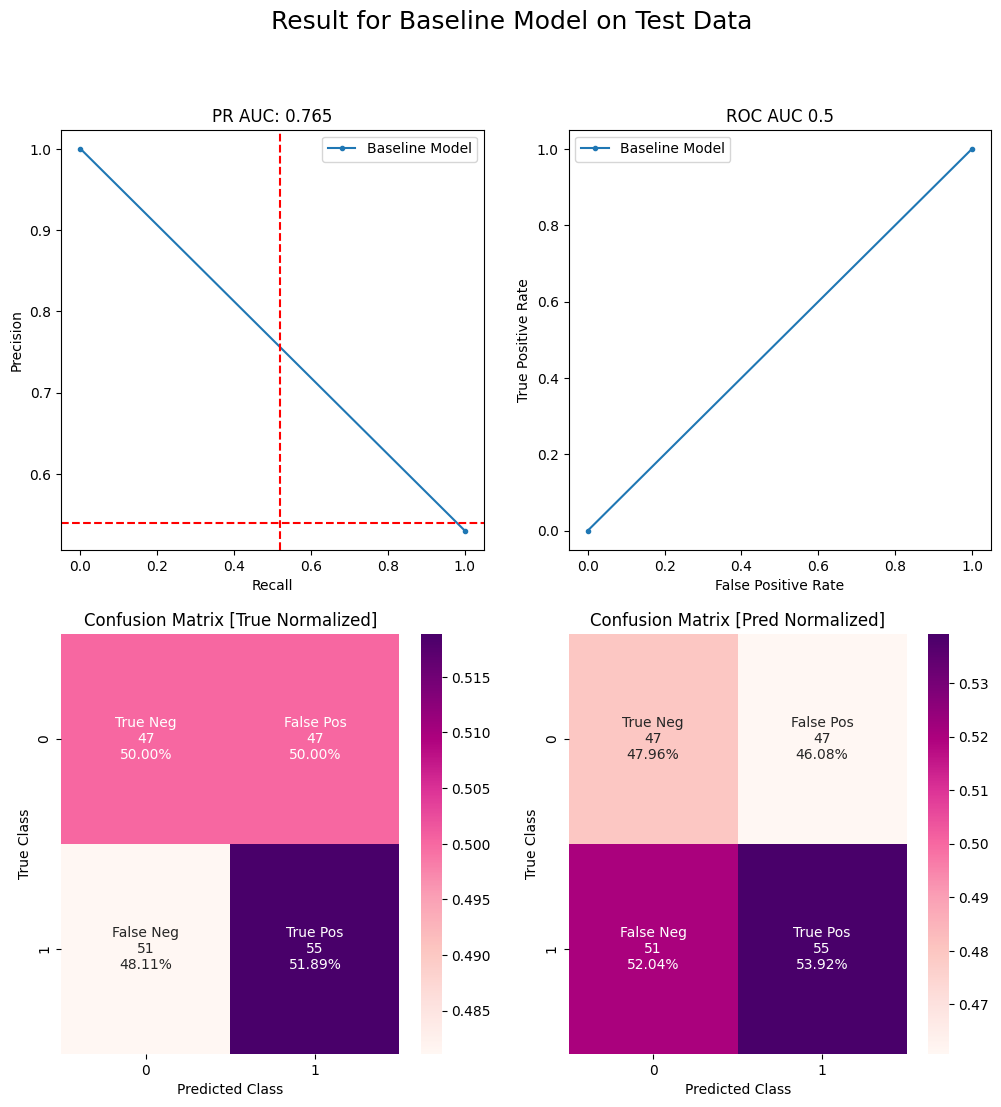

In [ ]:
result_disp(clf, X_train, X_test, y_train, y_test, 'Baseline Model')

We create a baseline classifier to evaluate the fact that our models perform better than random guessing. It helps us to assess how well the model distinguishes between the two classes.We see that the recall and precision is close to 0.5 which is the case for baseline classifiers. ROC value 0.5 indicates that the classifier make random guesses with no ability to distinguish positive and negative.  

#### Random Forest Classifier

In [ ]:
# Define the hyperparameter search space
search_space = {"n_estimators": (10, 1000), "max_depth": (1, 50),
                 "min_samples_split": (2, 10), "min_samples_leaf": (1, 10)}
# Initialize the random forest classifier
rf = RandomForestClassifier()
# Perform hyperparameter search
opt = bayes_opt_search(rf, search_space, X_train, y_train)
# Fit the random forest model with the best parameters
rf_best = RandomForestClassifier(**opt.best_params_)

Best Parameters:  OrderedDict([('max_depth', 1), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 220)])


In [ ]:
%%time
%%memit
rf_best.fit(X_train, y_train)

peak memory: 532.64 MiB, increment: 0.00 MiB
CPU times: user 198 ms, sys: 12.3 ms, total: 210 ms
Wall time: 961 ms



Training Data Scores:
Precision: 0.535761
Recall: 0.980952
F-Score: 0.693019
Accuracy: 0.543750

Test Data Scores:
Precision: 0.525773
Recall: 0.962264
F-Score: 0.680000
Accuracy: 0.520000




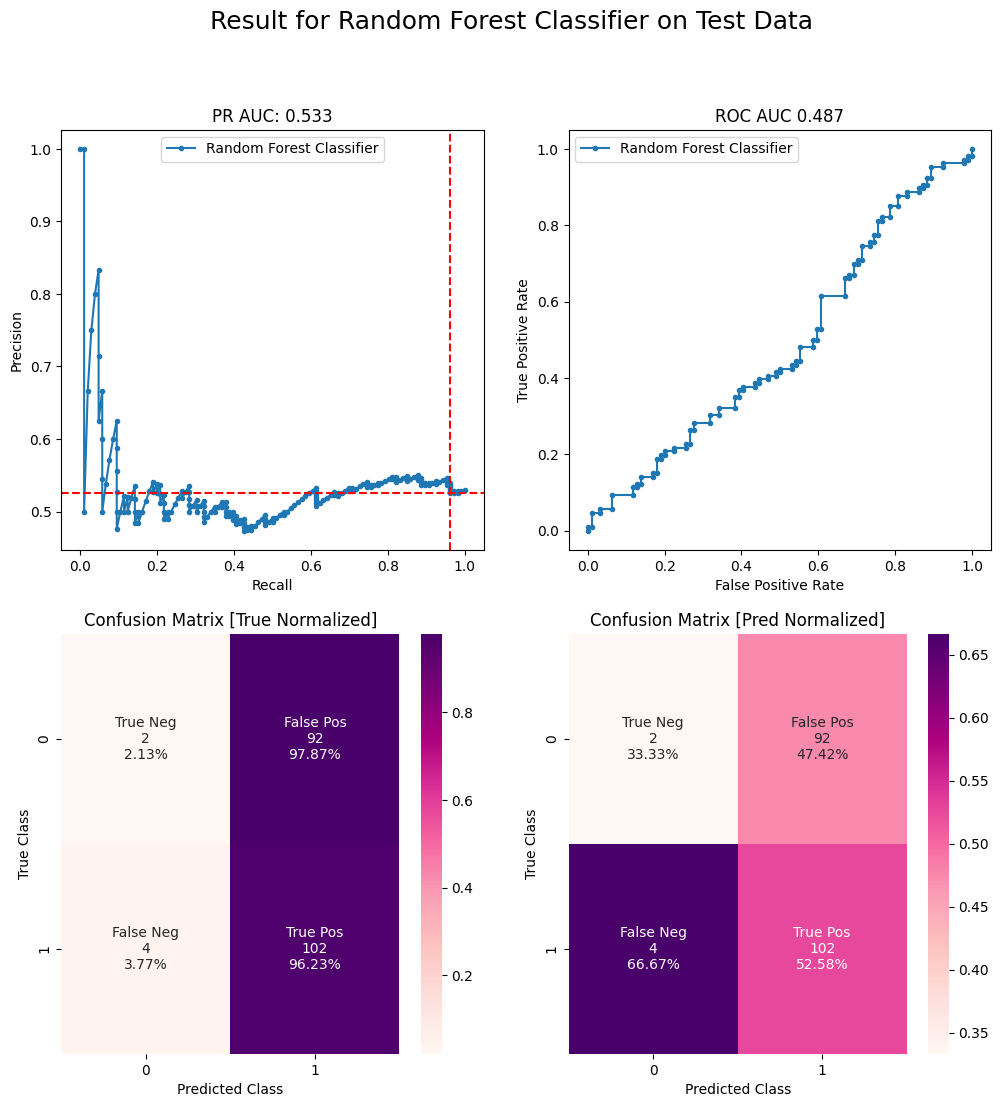

In [ ]:
result_disp(rf_best, X_train, X_test, y_train, y_test, 'Random Forest Classifier')

We see that the recall is higher than the precision, which is desirable in our case.

#### AdaBoost (Base Classifier: Decision Tree (default))

In [ ]:
search_space = {"n_estimators": (10, 1000), "learning_rate": (0.1, 1.0)}
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')
# Perform hyperparameter search
opt = bayes_opt_search(ada, search_space, X_train, y_train)
ada_best = AdaBoostClassifier(**opt.best_params_, algorithm='SAMME', random_state=42)

Best Parameters:  OrderedDict([('learning_rate', 0.12023983100592008), ('n_estimators', 10)])


In [ ]:
%%time
%%memit
ada_best.fit(X_train, y_train)

peak memory: 515.92 MiB, increment: 0.00 MiB
CPU times: user 317 ms, sys: 769 ms, total: 1.09 s
Wall time: 697 ms



Training Data Scores:
Precision: 0.531290
Recall: 0.990476
F-Score: 0.691604
Accuracy: 0.536250

Test Data Scores:
Precision: 0.538462
Recall: 0.990566
F-Score: 0.697674
Accuracy: 0.545000




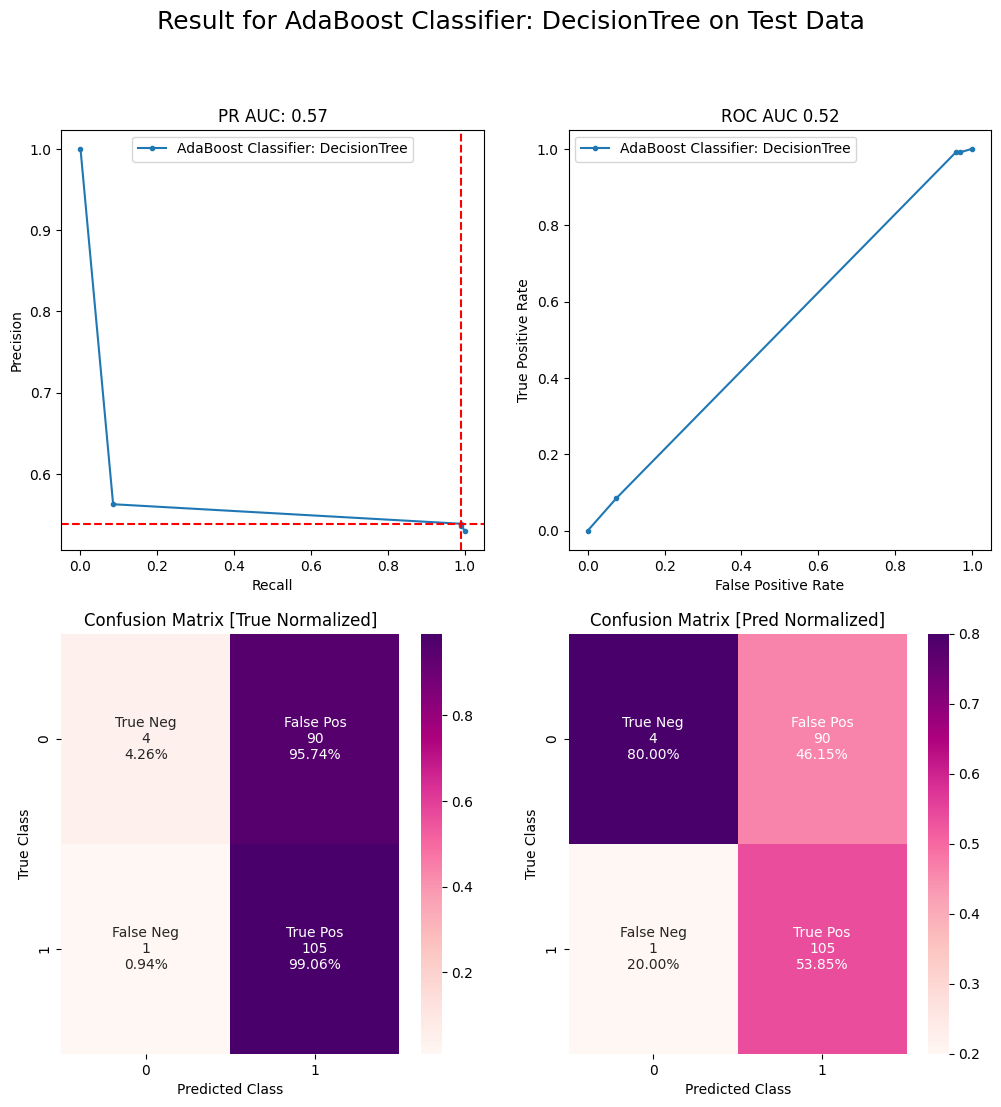

In [ ]:
result_disp(ada_best, X_train, X_test, y_train, y_test, 'AdaBoost Classifier: DecisionTree')

For AdaBoosting classifier, we also see that the recall is higher than precision. So this is our desired case.

We perform another AdaBoost classification to see if it improves the performance over the base learner as decision tree. We create a simple artifical neural network as our base learner for this case.

#### AdaBoost (Base Classifier: Neural Network)

In [ ]:
# Initialize the neural network
torch.manual_seed(42)
input_dim = X_train.shape[1]
ann = NeuralNetwork(input_dim).to('mps') # cuda:0

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device='mps') # cuda:0
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device='mps')

# Create a PyTorch dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the neural network
train_nn(ann, train_loader, epochs=1000, lr=0.05)

# Define a function to predict probabilities using the neural network
def predict_proba(ann, X):
    ann.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32, device='mps')
        outputs = ann(X_tensor)
        return outputs.detach().cpu().numpy()

# Obtain predictions from the neural network
X_train_nn_predictions = predict_proba(ann, X_train_tensor)
X_test_nn_predictions = predict_proba(ann, torch.tensor(X_test, dtype=torch.float32, device='mps'))

Epoch 100/1000, Loss: 1.0544
Epoch 200/1000, Loss: 0.6826
Epoch 300/1000, Loss: 0.6905
Epoch 400/1000, Loss: 0.6892
Epoch 500/1000, Loss: 0.6828
Epoch 600/1000, Loss: 0.6912
Epoch 700/1000, Loss: 0.6820
Epoch 800/1000, Loss: 0.7035
Epoch 900/1000, Loss: 0.6885
Epoch 1000/1000, Loss: 0.6855


In [ ]:
# Define adabost with ANN as the base estimator
search_space = {"n_estimators": (5, 100), "learning_rate": (0.1, 1.0)}
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')

# Perform hyperparameter search
opt = bayes_opt_search(ada, search_space, X_train_nn_predictions, y_train)

# Fit the AdaBoost classifier to the neural network predictions
ada_best_nn = AdaBoostClassifier(**opt.best_params_, algorithm='SAMME', random_state=42)

Best Parameters:  OrderedDict([('learning_rate', 0.46909356296798244), ('n_estimators', 74)])


In [ ]:
%%time
%%memit
ada_best_nn.fit(X_train_nn_predictions, y_train)

peak memory: 559.42 MiB, increment: 0.00 MiB
CPU times: user 381 ms, sys: 714 ms, total: 1.1 s
Wall time: 980 ms



Training Data Scores:
Precision: 0.525000
Recall: 1.000000
F-Score: 0.688525
Accuracy: 0.525000

Test Data Scores:
Precision: 0.530000
Recall: 1.000000
F-Score: 0.692810
Accuracy: 0.530000




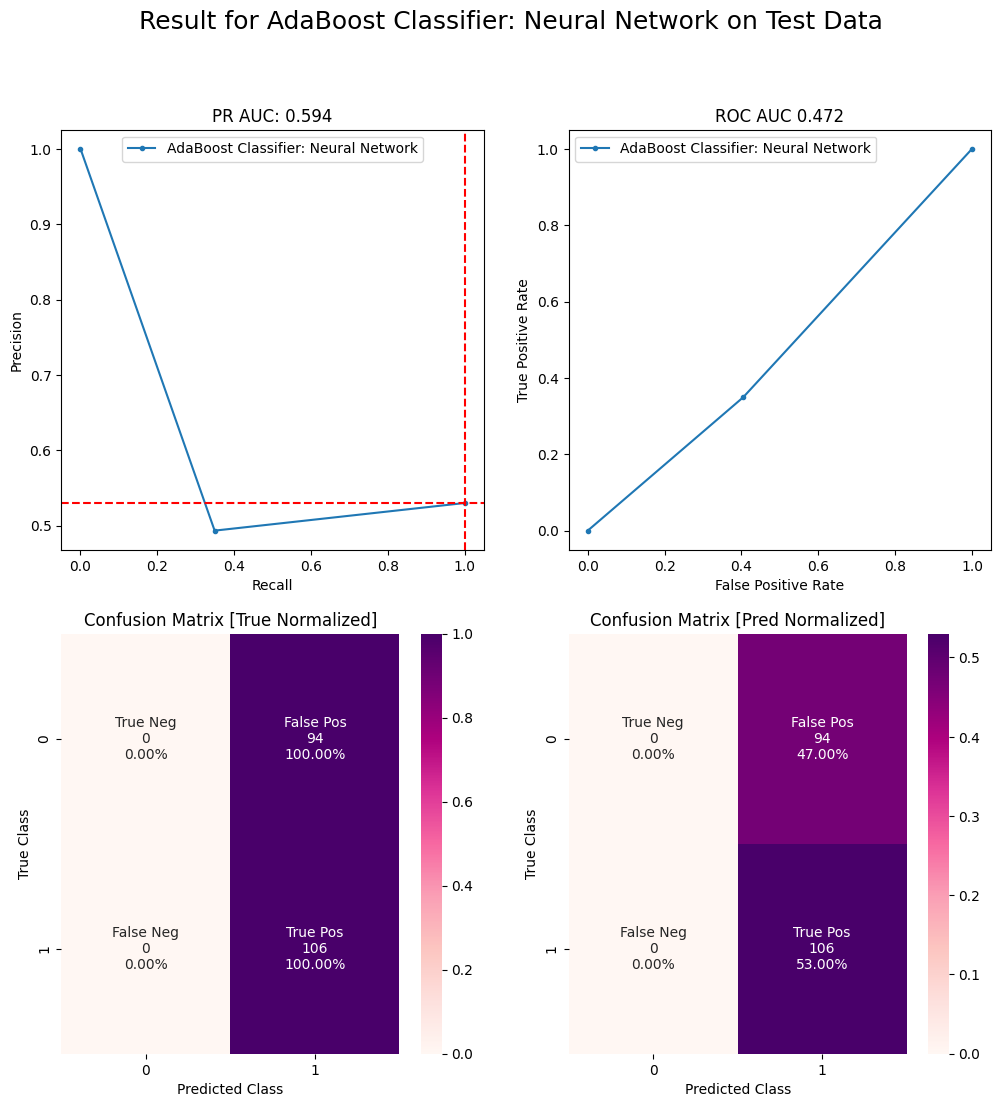

In [ ]:
result_disp(ada_best_nn, X_train_nn_predictions, X_test_nn_predictions, y_train, y_test, 'AdaBoost Classifier: Neural Network')

We see that recall is 1 in both cases. But the ROC value decreases. Thus we can say that adaboost with base learner as decision tree performs equally well. So recall is more in AdaBoost than random forest classifier. We can conclude that AdaBoost is better than random forest.

## Task 2: Supermarket Sales

**DATA** **DESCRIPTION** :  
This data comes from a Supermarket Sales. This contain the categorical details of branch, customer type, product type, payment type and numerical attributes of per unit price, quantity, tax, total and ratings. Analyzing this dataset provides the insight of a customer's gender. We predict the customer's gender by using two different algorithms, one is random forest and another is decision tree. Further, we also predict the rating by analysing the dataset using linear regression and decision tree regression.

### Exploratory Data-Analysis

In [ ]:
df = pd.read_csv('supermarket-sales-data.csv')
df.head()

,InvoiceID,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
0,750-67-8428,A,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,UPI,9.1
1,226-31-3081,C,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,9.6
2,631-41-3108,A,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,7.4
3,123-19-1176,A,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,UPI,8.4
4,373-73-7910,A,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,UPI,5.3


In [ ]:
# Summary statistics
summary_stat_columns(df)

Summary statistics for numerical columns
         UnitPrice     Quantity          Tax        Total      Rating
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.00000
mean     55.672130     5.510000    15.379369   322.966749     6.97270
std      26.494628     2.923431    11.708825   245.885335     1.71858
min      10.080000     1.000000     0.508500    10.678500     4.00000
25%      32.875000     3.000000     5.924875   124.422375     5.50000
50%      55.230000     5.000000    12.088000   253.848000     7.00000
75%      77.935000     8.000000    22.445250   471.350250     8.50000
max      99.960000    10.000000    49.650000  1042.650000    10.00000

Summary statistics for categorical columns
          InvoiceID Branch CustomerType  Gender          ProductType  \
count          1000   1000         1000    1000                 1000   
unique         1000      3            2       2                    6   
top     750-67-8428      A       Member  Female  Fashion accessories 

In [ ]:
# Separating all the numerical columns and categorical columns
numerical_columns, categorical_columns = get_numerical_and_categorical_columns(df)

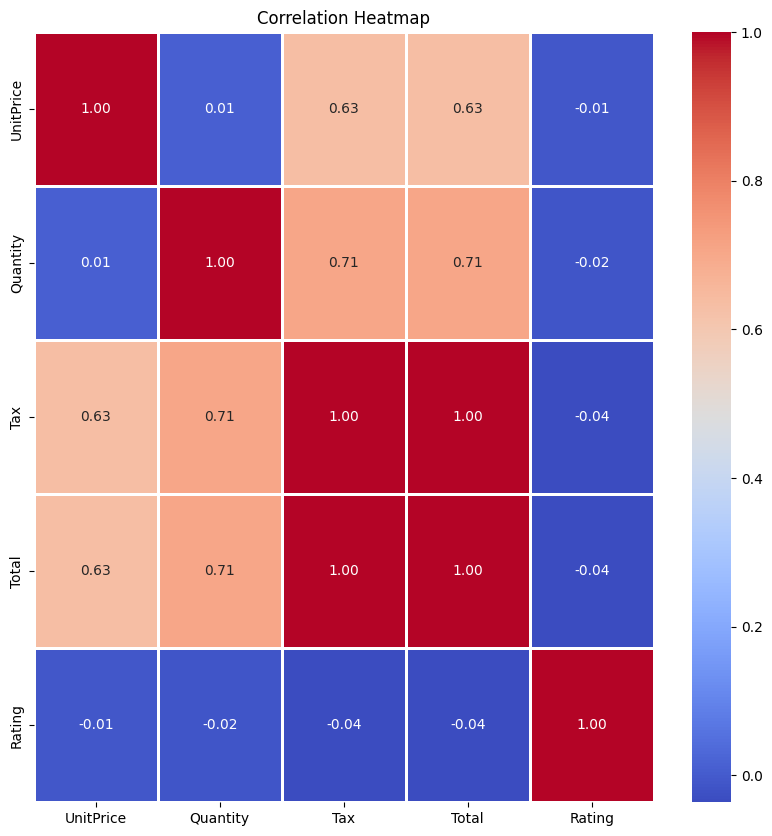

In [ ]:
# Correlation heatmap of numerical features
correlation_heatmap(df, numerical_columns)

We can observe that the correlation coefficient between 'Tax' and 'Total' is 1, so they are highly correlated. We can drop any one of them. Here we drop the 'Tax' attribute.

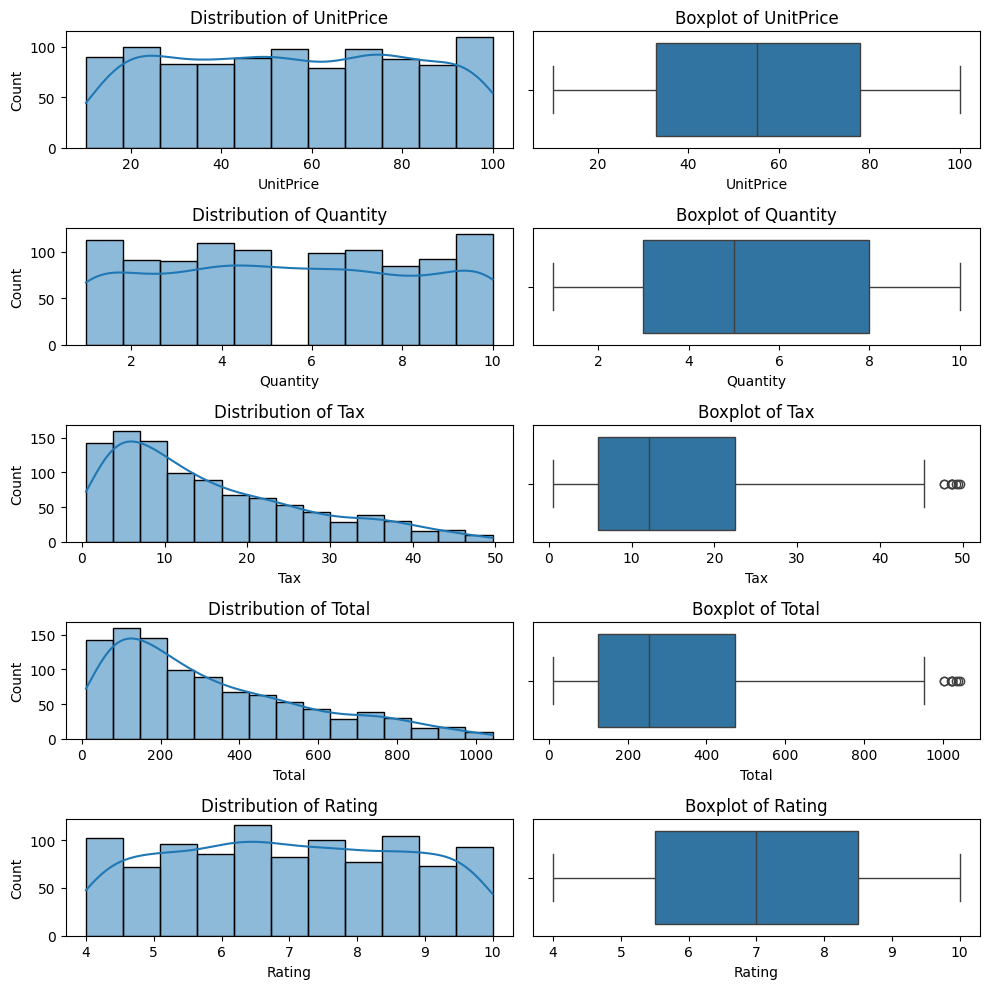

In [ ]:
# Remove 'Invoice ID' from the list if it exists
if 'InvoiceID' in numerical_columns:
    numerical_columns.remove('InvoiceID')
elif 'InvoiceID' in categorical_columns:
    categorical_columns.remove('InvoiceID')

plot_distribution_numerical(df, numerical_columns)

We have checked the distribution of each numerical attribute.

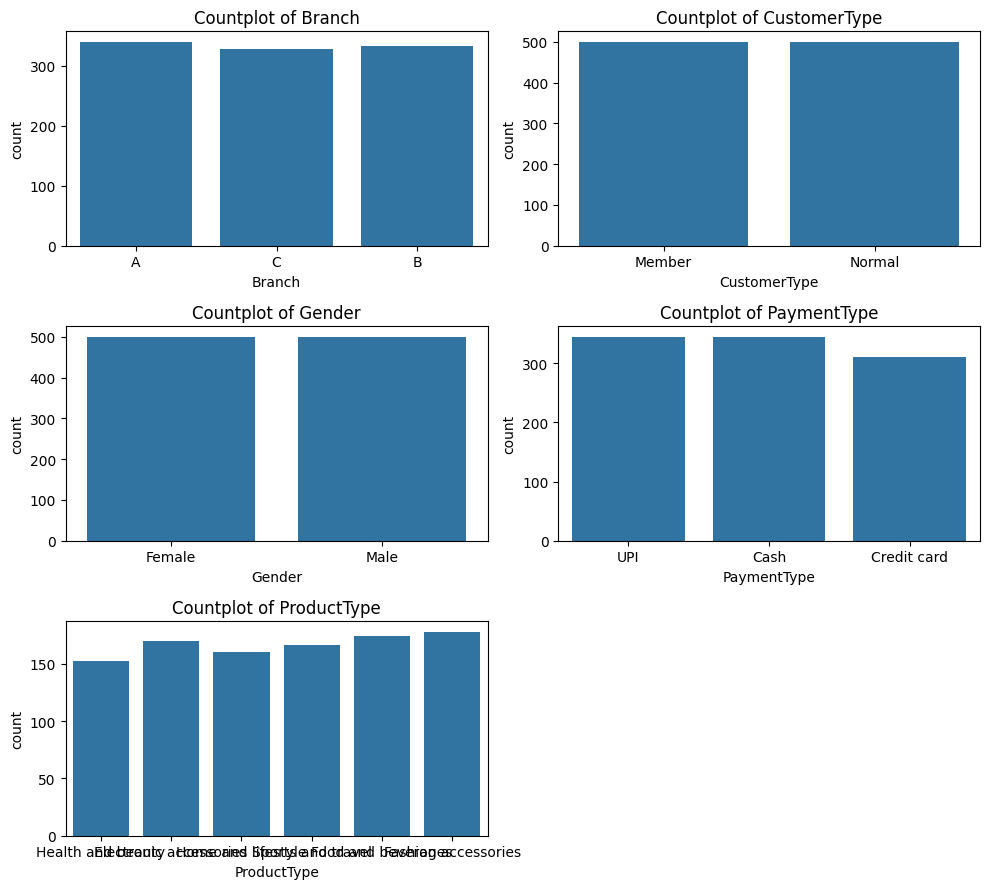

In [ ]:
# Countplot of categorical columns
plot_count_categorical(df, categorical_columns)

From these plots, we can say that there is no imbalance in our data.

### Gender Classification

#### Data Pre-Processing

In [ ]:
# Get train test data along with preprocessing pipeline

# Removing InvoiceID and Tax (Tax is exactly correlated with Total)
# Removing outliers from Total
X_train, X_test, y_train, y_test, preprocessor = get_data(df, cols_to_remove=['InvoiceID', 'Tax'],
                                                           target='Gender', outlier_col='Total',
                                                           preprocess=True)
X_train, y_train, preprocessor = preprocess_data(X_train, y_train, preprocessor, train_data=True)
X_test, y_test, preprocessor = preprocess_data(X_test, y_test, preprocessor, train_data=False)
# Sanity check (Check if the data is ready for modeling)
assert np.sum(random.choice(X_train) == 1) == len(categorical_columns)-1, "Categorical variables not handled properly"
assert np.sum(random.choice(X_train) != 0) == len(numerical_columns)-1+len(categorical_columns)-1, "Numerical variables not handled properly"

Shape of training set: (800, 10) (800,)
Shape of test set: (200, 10) (200,)
numerical_columns in training data: ['UnitPrice', 'Quantity', 'Total', 'Rating']
categorical_columns in training data: ['Branch', 'CustomerType', 'PaymentType', 'ProductType']


#### Model Fitting

##### Baseline Classifier

In [ ]:
%%time
%%memit
clf = Baseline(y_train)

peak memory: 435.33 MiB, increment: 0.05 MiB
CPU times: user 109 ms, sys: 17.2 ms, total: 126 ms
Wall time: 750 ms



Training Data Scores:
Precision: 0.487374
Recall: 0.488608
F-Score: 0.487990
Accuracy: 0.493750

Test Data Scores:
Precision: 0.530612
Recall: 0.500000
F-Score: 0.514851
Accuracy: 0.510000




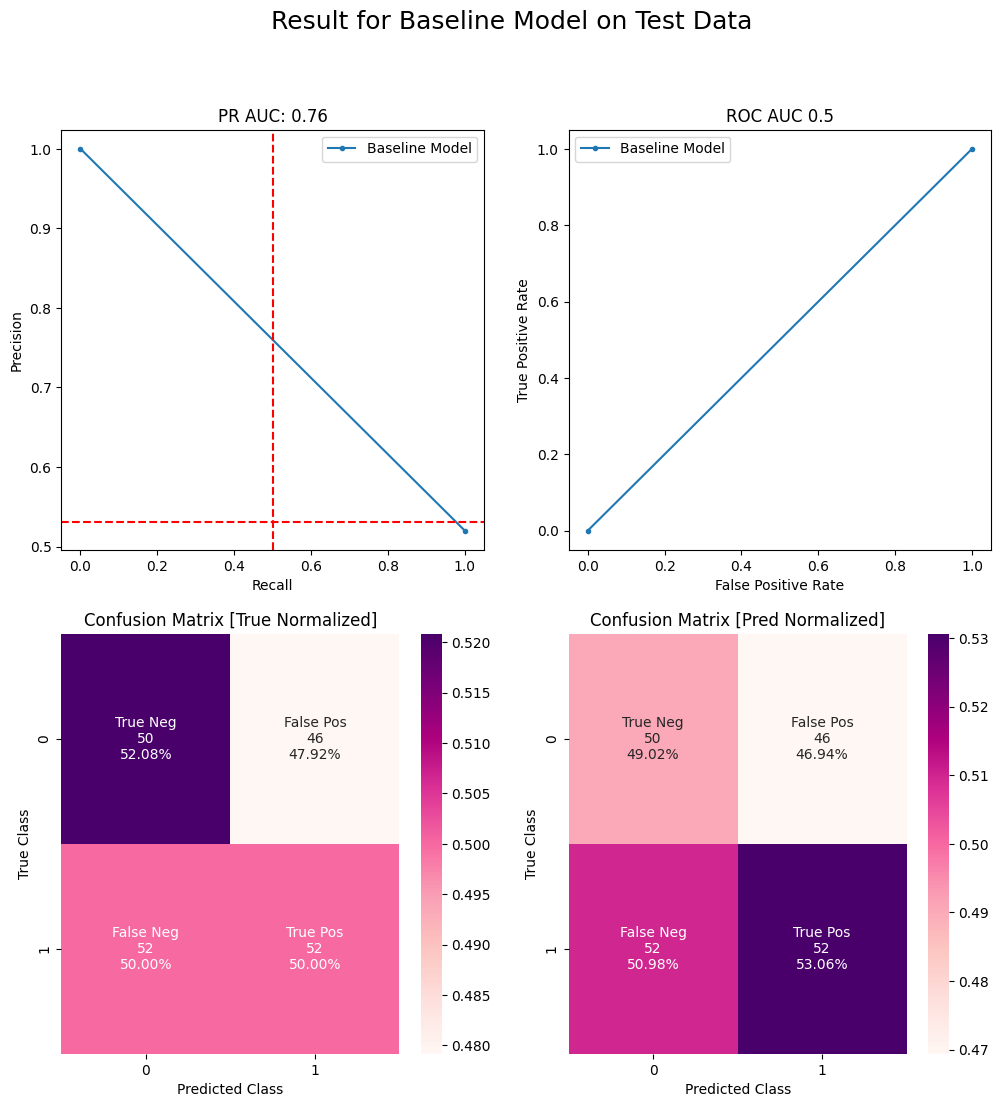

In [ ]:
result_disp(clf, X_train, X_test, y_train, y_test, 'Baseline Model')

Creating a baseline model for comparison with our other models.

##### Decision Tree

In [ ]:
# Define the hyperparameter search space for decision tree
search_space = { 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'],
                'max_depth': (1, 50), 'min_samples_split': (2, 10), 'min_samples_leaf': (1, 10)}
# Initialize decsion tree classifier
dt = DecisionTreeClassifier()
# Perform hyperparameter search
opt = bayes_opt_search(dt, search_space, X_train, y_train)
# Fit the decision tree model with the best parameters
dt_best = DecisionTreeClassifier(**opt.best_params_)

Best Parameters:  OrderedDict([('criterion', 'entropy'), ('max_depth', 33), ('min_samples_leaf', 9), ('min_samples_split', 5), ('splitter', 'best')])


In [ ]:
%%time
%%memit
dt_best.fit(X_train, y_train)

peak memory: 536.08 MiB, increment: 0.00 MiB
CPU times: user 261 ms, sys: 689 ms, total: 950 ms
Wall time: 970 ms



Training Data Scores:
Precision: 0.755968
Recall: 0.721519
F-Score: 0.738342
Accuracy: 0.747500

Test Data Scores:
Precision: 0.615385
Recall: 0.538462
F-Score: 0.574359
Accuracy: 0.585000




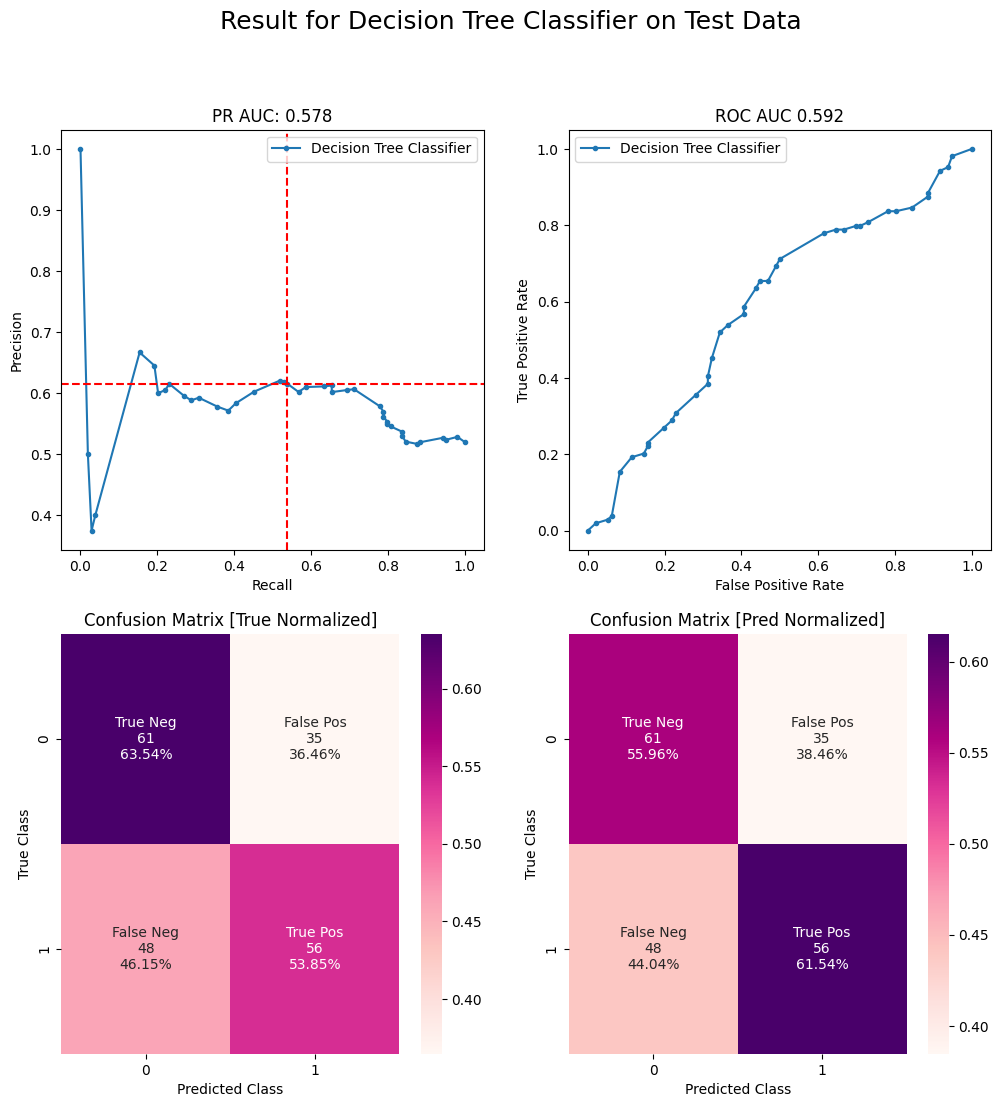

In [ ]:
result_disp(dt_best, X_train, X_test, y_train, y_test, 'Decision Tree Classifier')

##### Random Forest

In [ ]:
# Define the hyperparameter search space
search_space = {"n_estimators": (10, 500), "max_depth": (1, 50),
                "min_samples_split": (2, 10), "min_samples_leaf": (1, 10),
                "criterion": ("gini", "entropy")}
# Initialize the random forest classifier
rf = RandomForestClassifier()
# Perform hyperparameter search
opt = bayes_opt_search(rf, search_space, X_train, y_train)
# Fit the random forest model with the best parameters
rf_best = RandomForestClassifier(**opt.best_params_)

Best Parameters:  OrderedDict([('criterion', 'entropy'), ('max_depth', 47), ('min_samples_leaf', 4), ('min_samples_split', 5), ('n_estimators', 424)])


In [ ]:
%%time
%%memit
rf_best.fit(X_train, y_train)

peak memory: 524.41 MiB, increment: -2.00 MiB
CPU times: user 423 ms, sys: 22.1 ms, total: 445 ms
Wall time: 1.08 s



Training Data Scores:
Precision: 0.948718
Recall: 0.936709
F-Score: 0.942675
Accuracy: 0.943750

Test Data Scores:
Precision: 0.556962
Recall: 0.423077
F-Score: 0.480874
Accuracy: 0.525000




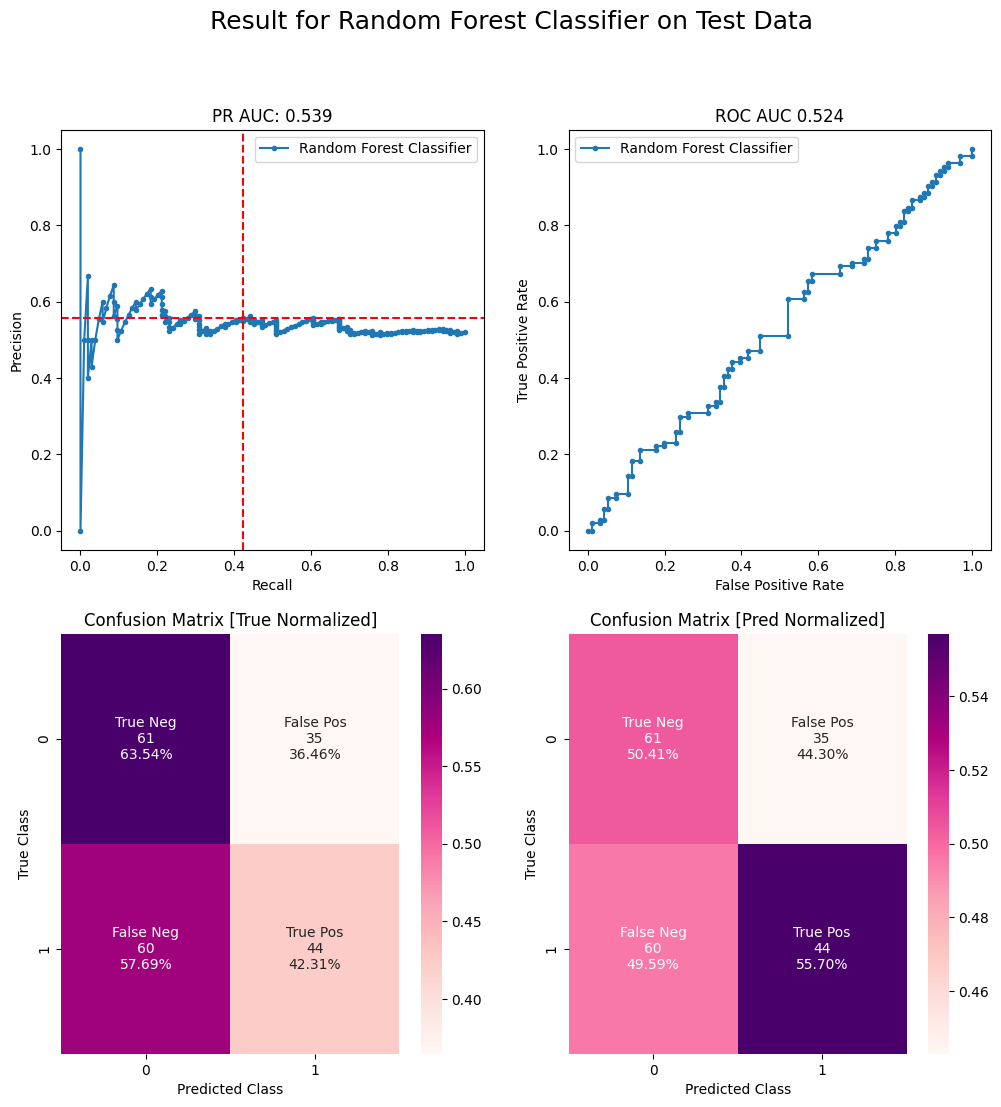

In [ ]:
result_disp(rf_best, X_train, X_test, y_train, y_test, 'Random Forest Classifier')

For our 'Gender' predicting case, decision tree performs better than random forest classifier in terms of the AUC score.

### Rating Prediction

In [ ]:
## Read the data again for regression task
df = pd.read_csv('supermarket-sales-data.csv')
# Separating all the numerical columns and categorical columns
numerical_columns, categorical_columns = get_numerical_and_categorical_columns(df)
# Get train test data along with preprocessing pipeline
X_train, X_test, y_train, y_test, preprocessor = get_data(df, cols_to_remove=['InvoiceID', 'Tax'],
                                                          target='Rating', outlier_col='Total',
                                                          classification=False, process_target=True, preprocess=True)
X_train, y_train, preprocessor = preprocess_data(X_train, y_train, preprocessor, train_data=True, classification=False)
X_test, y_test, preprocessor = preprocess_data(X_test, y_test, preprocessor, train_data=False, classification=False)
# Sanity check (Check if the data is ready for modeling)
assert np.sum(random.choice(X_train) == 1) == len(categorical_columns)-1, "Categorical variables not handled properly"
assert np.sum(random.choice(X_train) != 0) == len(numerical_columns)-2+len(categorical_columns)-1, "Numerical variables not handled properly"

Shape of training set: (800, 10) (800,)
Shape of test set: (200, 10) (200,)
numerical_columns in training data: ['UnitPrice', 'Quantity', 'Total']
categorical_columns in training data: ['Branch', 'CustomerType', 'Gender', 'PaymentType', 'ProductType']


#### Linear Regression

In [ ]:
# Add intercept term to the feature matrix
X_train_with_intercept = sm.add_constant(X_train)

In [ ]:
%%time
%%memit
# Fit the linear regression model with intercept
lm_model = sm.OLS(y_train, X_train).fit()

peak memory: 372.41 MiB, increment: 0.42 MiB
CPU times: user 173 ms, sys: 157 ms, total: 330 ms
Wall time: 733 ms


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7672
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.706
Time:                        16:36:41   Log-Likelihood:                -1129.7
No. Observations:                 800   AIC:                             2289.
Df Residuals:                     785   BIC:                             2360.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0922      0.075      1.225      0.2

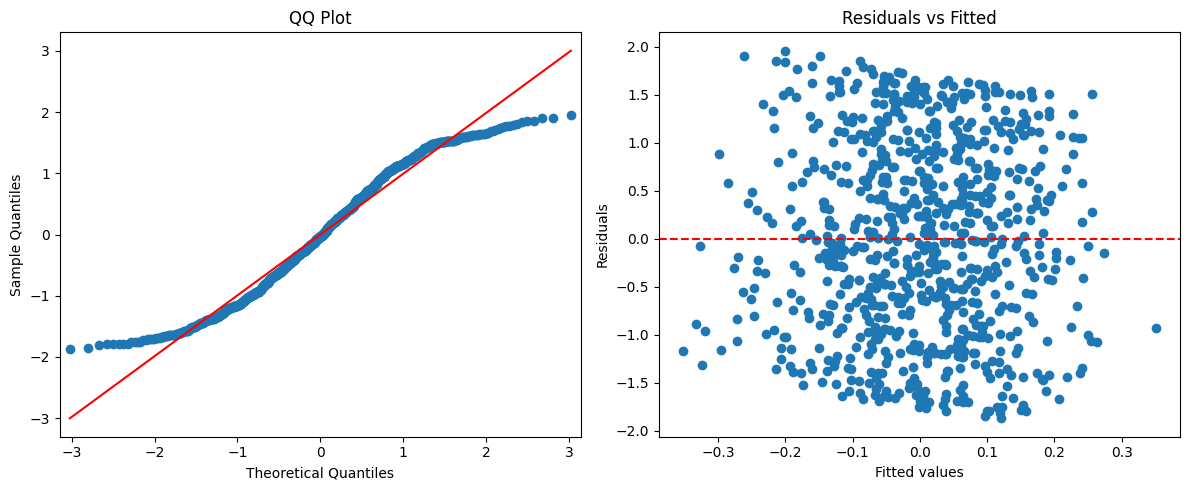

In [ ]:
# Obtain model summary
print(lm_model.summary())
lm_plot_diagnostics(lm_model)

The QQ plot deviates from the 45 degree line which shows that the sample and theoritical quantiles are drawn from non identical distributions and thus the errors are dreawn from a gaussian distn. This violates the assumptions of fitting a linear regression and thus justifies why linear regression fails to predict the ratings, as we can see from the values in our (above) regression results.

In [ ]:
regression_report(lm_model, X_train, y_train, X_test, y_test, preprocessor)

Training MSE: 0.9865024260715546
Test MSE: 1.0654542371239861
Training R^2: 0.013497573928445195
Test R^2: -0.01381683650370702
Training MSE (Unnormalized): 2.8797175901390606
Test MSE (Unnormalized): 3.110187291026072
Training R^2 (Unnormalized): 0.013497573928445306
Test R^2 (Unnormalized): -0.01381683650370702


#### Decision Tree Regressor

In [ ]:
# Define the hyperparameter search space for decision tree
search_space = { 'criterion': Categorical(['squared_error', 'absolute_error']),
                'max_depth': Integer(1, 100), 'min_samples_split': Integer(2, 10),
                'min_samples_leaf': Integer(1,50)}
# Initialize decsion tree classifier
dt_reg = DecisionTreeRegressor()
# Perform hyperparameter search
opt = bayes_opt_search(dt_reg, search_space, X_train, y_train, regression=True)
# Fit the decision tree model with the best parameters
dt_reg_best = DecisionTreeRegressor(**opt.best_params_)

Best Parameters:  OrderedDict([('criterion', 'squared_error'), ('max_depth', 1), ('min_samples_leaf', 43), ('min_samples_split', 10)])


In [ ]:
%%time
%%memit
dt_reg_best.fit(X_train, y_train)

peak memory: 460.41 MiB, increment: -86.44 MiB
CPU times: user 470 ms, sys: 792 ms, total: 1.26 s
Wall time: 1.22 s


In [ ]:
regression_report(dt_reg_best, X_train, y_train, X_test, y_test, preprocessor)

Training MSE: 0.9904581944030645
Test MSE: 1.062974846674349
Training R^2: 0.009541805596935404
Test R^2: -0.011457610086912373
Training MSE (Unnormalized): 2.8912649470899474
Test MSE (Unnormalized): 3.10294965622463
Training R^2 (Unnormalized): 0.009541805596935404
Test R^2 (Unnormalized): -0.011457610086912595


As we have seen in the linear regression case that the p values are not large enough. Hence none of the attributes contribute significantly in the final result of regression. Still from the report values, decision tree regressor performs better than linear regression.

# **CONCLUSION** :
**1. For Churn Dataset :**

***Baseline Classifier*** - Time : 95.3 ms, Space : 0.00 MiB

***Random Forest Classifier*** - Time : 210 milisecond , Space : 0.00 MiB

***AdaBoost Classifier*** - Time : 1.1 second , Space : 0.00 MiB

**2.For Supermarket Sales :**

***Baseline Time*** : 126 ms, Space : 0.05 MiB

***Decision Tree*** - Time : 950 ms , Space : 0.00 MiB

***Random Forest*** - Time : 445 ms , Space : 2 MiB

***Linear regression*** - Time : 330 ms , Space : 0.42 MiB

***Decision Tree regressor*** - Time : 1.26 s , Space : 86.44 MiB

Here Space represents increment in memory after calling the trainning procedure of the given machine learning model.